# Hindcasting with CaSPAr-Archived ECCC forecasts

This notebook shows how to perform a streamflow hindcast, using CaSPar archived weather forecasts. It generates the hindcasts and plots them.

CaSPAr (Canadian Surface Prediction Archive) is an archive of historical ECCC forecasts developed by Juliane Mai at the University of Waterloo, Canada. More details on CaSPAr can be found here https://caspar-data.ca/.


Mai, J., Kornelsen, K.C., Tolson, B.A., Fortin, V., Gasset, N., Bouhemhem, D., Schäfer, D., Leahy, M., Anctil, F. and Coulibaly, P., 2020. The Canadian Surface Prediction Archive (CaSPAr): A Platform to Enhance Environmental Modeling in Canada and Globally. Bulletin of the American Meteorological Society, 101(3), pp.E341-E356.


In [1]:
# This entire section is cookie-cutter template to import required packages and prepare the temporary writing space.
import datetime as dt
from matplotlib import pyplot as plt
from ravenpy.utilities import forecasting
from ravenpy.utilities.forecasting import get_CASPAR_dataset
from ravenpy.utilities.testdata import get_file
from ravenpy.models import HRU, GR4JCN
from clisops.core import subset, average
import xarray as xr
import json
import tempfile
import xskillscore
from pathlib import Path

tmp = Path(tempfile.mkdtemp())

## Run the model simulations

Here we set model parameters somewhat arbitrarily, but you can set the parameters to the calibrated parameters as seen in the "06_Raven_calibration" notebook we previously encountered. We can then specify the start date for the hindcast ESP simulations and run the simulations.This means we need to choose the forecast (hindcast) date. Available data include May 2017 onwards.

In [2]:
# Date of the hindcast
hdate = dt.datetime(2018, 6, 1)

# Get the Forecast data from GEPS via CASPAR
ts_hindcast, _ = get_CASPAR_dataset("GEPS",hdate)

# Subset the data for the region of interest and take the mean to get a single vector
ts_subset = subset.subset_shape(ts_hindcast,'input.geojson').mean(dim=('rlat', 'rlon'))
ts_subset = ts_subset.resample(time='6H').nearest(tolerance='1H') # To make the timesteps identical accross the entire duration



In [3]:
# Prepare a RAVEN model run using historical data, GR4JCN in this case.
# This is a dummy run to get initial states. In a real forecast situation,
# this run would end on the day before the forecast, but process is the same.

# Here we need a file of observation data to run a simulation to generate initial conditions for our forecast.
ts = str(get_file("raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc"))


# Here we add the physiographic data needed by Raven models.
hrus = (
    GR4JCN.LandHRU(area=4250.6, elevation=843.0, latitude=54.4848, longitude=-123.3659),
        )

# Choose a hydrological model to use. We have 'HMETS', 'GR4JCN','MOHYSE', 'HBVEC' and 'BLENDED'.
model = GR4JCN()

# And run the model with the desired inputs!
model(ts, 
      start_date = dt.datetime(2000,1,1),
      end_date = dt.datetime(2002,6,1),
      hrus=hrus,
      params = (0.529, -3.396, 407.29, 1.072, 16.9, 0.947),
)

# Extract the final states that will be used as the next initial states
rvc = model.outputs["solution"]

# Duration of the hindcast, in days
duration = 10

In [4]:
# It is necessary to clean the model state because the input variables of the previous
# model are not the same as the ones provided in the forecast model. therefore, if we
# do not clean, the model will simply add the hindcast file to the list of available
# data provided in the testdata above. Then the dates will not work, and the model errors.
model = GR4JCN()

# Using a hot-start to ensure the forecasts are more reasonable. Typically we would use either the end of a previous simulation
# window, or an assimilated state. Here we use an arbitrary value from the simulation from the above section
model.config.rvc.parse_solution(rvc.read_text())

# And run the model with the forecast data.
number_members=len(ts_subset.member.data)

# We need to write the netcdf data as a file for Raven to be able to access it.
ts_subset.to_netcdf(tmp / 'hindcast.nc')  
    
model(
            ts=str(tmp / 'hindcast.nc'),
            nc_index=range(number_members),
            start_date=hdate,
            end_date=hdate+dt.timedelta(days=duration),
            hrus=hrus,
            params=(0.529, -3.396, 407.29, 1.072, 16.9, 0.947),
            overwrite=True,
            pr={   # This part is to scale the precipitation and temperature as well as align the UTC time zome differences
                "scale": 1000.0,
                "offset": 0.0,
                "time_shift": -0.25,
                "deaccumulate": True,
            },
            tas={"time_shift": -0.25},
)

In [5]:
# We now have the forecasted flows for the desired date. We can access them as:
print(model.q_sim)

<xarray.DataArray 'q_sim' (time: 11, nbasins: 20)>
array([[69.016795, 69.016795, 69.016795, ..., 69.016795, 69.016795, 69.016795],
       [67.57608 , 67.185299, 67.184566, ..., 67.585889, 67.73704 , 67.739188],
       [66.278988, 65.444157, 65.442179, ..., 66.302811, 66.622822, 66.627768],
       ...,
       [57.043204, 59.07744 , 58.10924 , ..., 57.083818, 67.491492, 68.499504],
       [55.704691, 57.678467, 56.839855, ..., 55.716817, 64.737219, 67.103744],
       [63.287142, 59.384779, 57.594975, ..., 54.395231, 63.087635, 66.480141]])
Coordinates:
  * time        (time) datetime64[ns] 2018-06-01 2018-06-02 ... 2018-06-11
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows


### And, for visual representation of the forecasts:

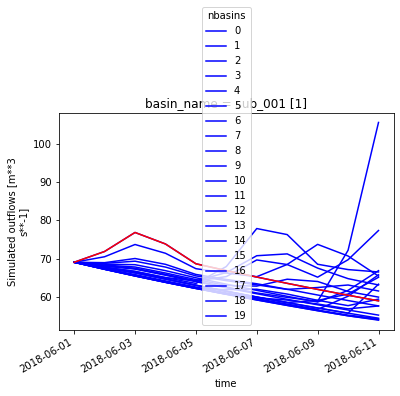

In [6]:
import matplotlib.pyplot as plt


# Simulate an observed streamflow timeseries: Here we take a member from the ensemble, but you should use your own
# observed timeseries:
qq = model.q_sim.isel(nbasins=10)

# This is to be replaced with a call to the forecast graphing WPS as soon as merged.
model.q_sim.plot.line("b", x="time")
qq.plot.line("r")
plt.show()